In [ ]:
import pandas as pd
import numpy as np

# This is map specific stuff - use conda install folium
import folium
from folium import plugins

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

chicago_crime = pd.read_csv('./data/chicago_crime.csv')

In [ ]:
chicago_crime.info()

Which crimes do I want to avoid?

In [3]:
chicago_crime['Primary Type'].value_counts()

THEFT                                64212
BATTERY                              49198
CRIMINAL DAMAGE                      29026
ASSAULT                              19287
DECEPTIVE PRACTICE                   18373
OTHER OFFENSE                        17127
BURGLARY                             12984
ROBBERY                              11880
NARCOTICS                            11569
MOTOR VEHICLE THEFT                  11419
CRIMINAL TRESPASS                     6812
WEAPONS VIOLATION                     4683
OFFENSE INVOLVING CHILDREN            2226
CRIM SEXUAL ASSAULT                   1588
PUBLIC PEACE VIOLATION                1497
INTERFERENCE WITH PUBLIC OFFICER      1084
SEX OFFENSE                            984
PROSTITUTION                           734
HOMICIDE                               671
ARSON                                  445
LIQUOR LAW VIOLATION                   191
GAMBLING                               191
KIDNAPPING                             190
STALKING   

In [4]:
crimes_to_avoid = ['BATTERY', 'ASSAULT', 'NARCOTICS', 'WEAPONS VIOLATION', 'SEX OFFENSE', 'PROSTITUTION', 'HOMICIDE', 'ARSON', 'INTIMIDATION', 
                   'KIDNAPPING', 'HUMAN TRAFFICKING']

print('Number of crimes searched for: ' , len(crimes_to_avoid))

print('Number of crimes found (used to check for typos in list!): ', len(chicago_crime.loc[chicago_crime['Primary Type'].isin(crimes_to_avoid),'Primary Type'].value_counts()))

filter_mask = chicago_crime['Primary Type'].isin(crimes_to_avoid) & (chicago_crime['Domestic'] == False) & \
              (~chicago_crime['Latitude'].isnull()) & (~chicago_crime['Longitude'].isnull())

avoid_crimes = chicago_crime[filter_mask]

('Number of crimes searched for: ', 11)
('Number of crimes found (used to check for typos in list!): ', 11)


In [5]:
avoid_crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57643 entries, 5 to 266882
Data columns (total 22 columns):
ID                      57643 non-null int64
Case Number             57643 non-null object
Date                    57643 non-null object
Block                   57643 non-null object
IUCR                    57643 non-null object
Primary Type            57643 non-null object
Description             57643 non-null object
Location Description    57643 non-null object
Arrest                  57643 non-null bool
Domestic                57643 non-null bool
Beat                    57643 non-null int64
District                57642 non-null float64
Ward                    57642 non-null float64
Community Area          57643 non-null int64
FBI Code                57643 non-null object
X Coordinate            57643 non-null float64
Y Coordinate            57643 non-null float64
Year                    57643 non-null int64
Updated On              57643 non-null object
Latitude            

In [7]:
chicago_map = folium.Map(location = [avoid_crimes['Latitude'].mean(), avoid_crimes['Longitude'].mean()], 
                         zoom_start = 13, tiles='Stamen Terrain')

In [8]:
chicago_map

In [9]:
locations = [list(loc) for loc in avoid_crimes[['Latitude', 'Longitude']].sample(20000).dropna().as_matrix()]

chicago_map.add_child(plugins.HeatMap(data=locations, name='crime_map', min_opacity=0.04, radius=10))
chicago_map

In [11]:
summary = avoid_crimes.describe(percentiles=[0.05,0.95])
summary

,ID,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
count,5.764300e+04,57643.000000,57642.000000,57642.000000,57643.000000,5.764300e+04,5.764300e+04,57643.0,57643.000000,57643.000000
mean,1.088056e+07,1101.369759,10.783786,22.213716,38.022449,1.163859e+06,1.884379e+06,2017.0,41.838349,-87.674264
std,1.142730e+06,649.888049,6.490197,12.988129,20.625782,1.626482e+04,3.001827e+04,0.0,0.082579,0.059181
min,2.305900e+04,111.000000,1.000000,1.000000,0.000000,1.094587e+06,1.814512e+06,2017.0,41.645796,-87.927365
5%,1.082175e+07,215.000000,2.000000,2.000000,6.000000,1.138977e+06,1.834301e+06,2017.0,41.700464,-87.765078
50%,1.099934e+07,1022.000000,10.000000,24.000000,31.000000,1.165058e+06,1.891597e+06,2017.0,41.858374,-87.669681
95%,1.116545e+07,2433.000000,24.000000,45.000000,71.000000,1.191176e+06,1.933178e+06,2017.0,41.972385,-87.575094
max,1.121316e+07,2535.000000,25.000000,50.000000,77.000000,1.205119e+06,1.951493e+06,2017.0,42.022536,-87.524542


In [12]:
longMin, longMax = summary.loc['5%', 'Longitude'], summary.loc['95%', 'Longitude']
latMin, latMax = summary.loc['5%', 'Latitude'], summary.loc['95%', 'Latitude']

BBGeoJSON = {
    'type':'Polygon',
    'coordinates':[[
        [longMin,latMin], [longMax,latMin],[longMax,latMax],[longMin,latMax],[longMin,latMin]        
    ]]
}

folium.GeoJson(
    BBGeoJSON,
    name='Bounding Box',
    style_function=lambda _: {
        'fillColor': '#DDDDDD',
        'color': '#FF8800',
        'weight': 2.1,
        'fillOpacity': 0.15,
    }
).add_to(chicago_map)

chicago_map

Let's restrict the "crimes to avoid" to this box

In [13]:
central_mask = ((latMin < avoid_crimes['Latitude']) & (avoid_crimes['Latitude'] < latMax) & 
                (longMin < avoid_crimes['Longitude']) & (avoid_crimes['Longitude'] < longMax))
avoid_crimes = avoid_crimes[central_mask]

## Make the size of a block 

Let's make lat and lon bins for our data

In [12]:
# 1 degree latitude is a distance of 2 pi R / 360. Want 0.25 mile x 0.25 mile blocks, so 
# 0.25 miles = 2 pi R_Earth / 360 (degree_size) => degree_size = (0.25 miles/R_Earth) x (360 deg/2pi)
lng_bin_size = (0.25/3900.0)*360/(2*3.1415)
lat_bin_size = (0.25/(3900.0*np.cos(np.radians(41.8))))*360/(2*3.1415)

to_bin = lambda x, bin_size: int(x/bin_size)*bin_size

avoid_crimes['lng_bin'] = avoid_crimes.Longitude.map(lambda x: to_bin(x, lng_bin_size))
avoid_crimes['lat_bin']= avoid_crimes.Latitude.map(lambda x: to_bin(x, lat_bin_size))
avoid_crimes['num_crime'] = 1

In [13]:
avoid_crimes.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,lng_bin,lat_bin,num_crime
5,10974196,JA298243,06/08/2017 04:02:00 PM,001XX E 59TH ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,ALLEY,True,False,...,1178308.0,1865932.0,2017,02/11/2018 03:54:58 PM,41.787427,-87.621759,"(41.78742694, -87.621758727)",-87.621053,41.785369,1
8,11157652,JA522842,11/23/2017 03:14:00 PM,003XX E 47TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,DEPARTMENT STORE,False,False,...,1178967.0,1873924.0,2017,02/11/2018 03:54:58 PM,41.809343,-87.619099,"(41.809342727, -87.619098999)",-87.617380,41.805077,1
13,11172603,JA541446,12/08/2017 03:00:00 AM,033XX S KEDZIE AVE,1020,ARSON,BY FIRE,"SCHOOL, PRIVATE, BUILDING",False,False,...,1155572.0,1882206.0,2017,03/01/2018 03:54:55 PM,41.832571,-87.704686,"(41.832571089, -87.704685773)",-87.701857,41.829711,1
27,11123850,JA478106,10/20/2017 01:15:00 AM,076XX S LOWE AVE,1020,ARSON,BY FIRE,VEHICLE NON-COMMERCIAL,False,False,...,1173288.0,1854309.0,2017,02/12/2018 03:49:14 PM,41.755645,-87.640508,"(41.755644606, -87.640508123)",-87.639418,41.750880,1
28,10929491,JA244606,04/29/2017 11:38:00 PM,028XX W 21ST PL,0496,BATTERY,AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST,APARTMENT,True,False,...,1157704.0,1889592.0,2017,02/12/2018 03:46:59 PM,41.852796,-87.696662,"(41.852796034, -87.696662196)",-87.694511,41.849419,1


In [14]:
summary_crimes = avoid_crimes[['lng_bin', 'lat_bin','num_crime']].groupby(['lng_bin', 'lat_bin']).count().reset_index()

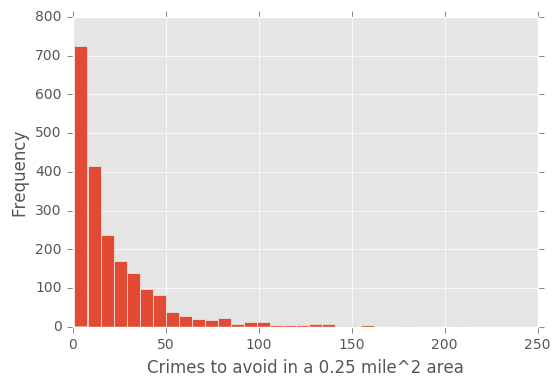

In [15]:
plt.hist(summary_crimes.num_crime,bins=50);

plt.xlabel('Crimes to avoid in a 0.25 mile^2 area')
plt.ylabel('Frequency');
plt.xlim(0,250);

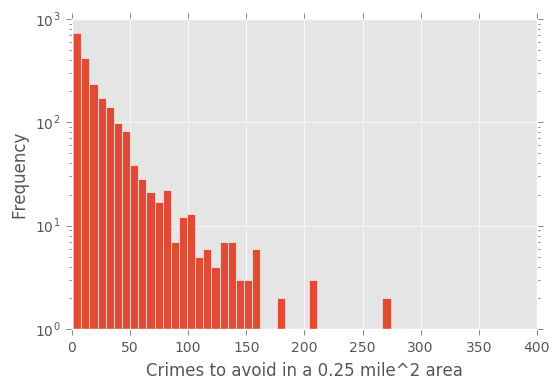

In [16]:
plt.hist(summary_crimes.num_crime,bins=50, log='y');

plt.xlabel('Crimes to avoid in a 0.25 mile^2 area')
plt.ylabel('Frequency');


In [17]:
summary_crimes.shape

(2078, 3)

## Building a decision tree

In [18]:
lat_edges = np.arange(avoid_crimes.Latitude.min(), avoid_crimes.Latitude.max(), lat_bin_size)
lng_edges = np.arange(avoid_crimes.Longitude.min(), avoid_crimes.Longitude.max(), lng_bin_size)

H, latitude_edges, longitude_edges = np.histogram2d(avoid_crimes.Latitude, avoid_crimes.Longitude, 
                                                    bins=(lat_edges, lng_edges))

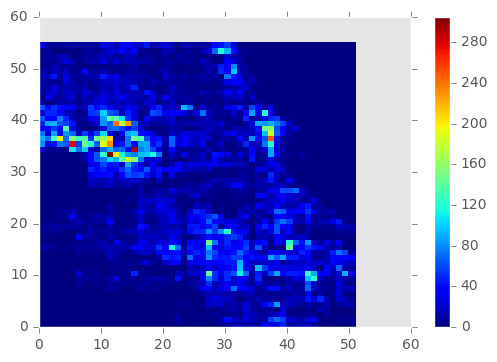

In [19]:
plt.pcolormesh(H)
plt.colorbar()

In [20]:
import itertools

df_crime = pd.DataFrame(list(itertools.product(lat_edges, lng_edges)))
np.ravel(H).shape, len(df_crime)

((2805,), 2912)

NameError: name 'xedges' is not defined

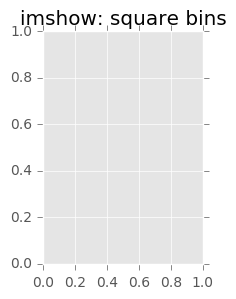

In [21]:
 
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(H, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [ ]:
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(H)
plt.set_cmap(plt.get_cmap('Oranges'))
plt.colorbar();

In [ ]:
chicago_crime[['Latitude', 'Longitude']].describe()

In [ ]:
avoid_crimes

In [ ]:
lat_grid = np.arange(41.64, 42.03, lat_bin)
lng_grid = np.arange(-87.9, -87.53, lng_bin)

In [ ]:
H, xedges, yedges = np.histogram2d(avoid_crimes['Latitude'].values, avoid_crimes['Longitude'].values, 
                                   bins=(lat_grid, lng_grid))


In [ ]:
plt.imshow(H, interpolation='nearest', origin='low',
           extent=[	41.779619, xedges[-1], yedges[0], yedges[-1]], clim=(0,120))
plt.set_cmap(plt.get_cmap('Oranges'))
plt.colorbar();

In [ ]:
from sklearn import tree


In [ ]:
X = [[0, 0], [1, 1],[2,2],[3,3],[4,4]]
Y = [0, 1,2,3,4]
classifier = tree.DecisionTreeClassifier()
classifier.fit(X,Y)
tree.export_graphviz(classifier, out_file='out.dot')

In [ ]:
!dot -Tpng out.dot -o out.png

In [ ]:
!open out.png

In [ ]:
classifier.predict([[3,3],[4,4], [1,2]])

In [ ]:
fakeCSV="""name,lat,lon
irrelevant,52,-87.7"""


In [ ]:
#thedata = geoplotlib.utils.read_csv('temp.csv')
geoplotlib.dot(thedata)
geoplotlib.show()

In [ ]:
geoplotlib.dot(avoid_crimes.rename({'Latitude': 'lat', 'Longitude': 'lon'}))
geoplotlib.show()

In [ ]:
plt.hist(np.ravel(H), bins=300);
plt.xlim(3,30)
plt.ylim(0,1000)